In [ ]:
!pip install georasters
import georasters as gr
import pandas as pd
import numpy as np
import warnings
np.warnings = warnings

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━

In [ ]:
#https://human-settlement.emergency.copernicus.eu/download.php


<Axes: >

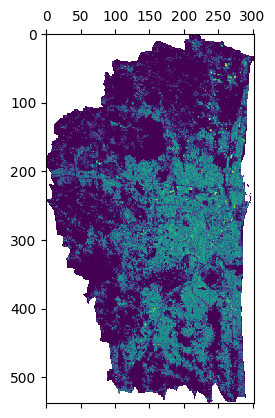

In [ ]:
pdensity = gr.from_file('ChennaiPD.tif')
pdensity.plot()

In [ ]:
pdensity = pdensity.to_pandas()
pdensity


,value,x,y,row,col
0,106.0,7910350.0,1637750.0,0,216
1,168.0,7910450.0,1637750.0,0,216
2,267.0,7910950.0,1637750.0,0,222
3,0.0,7910750.0,1637700.0,1,220
4,1.0,7910350.0,1637650.0,2,216
...,...,...,...,...,...
84552,920.0,7915650.0,1584150.0,536,268
84553,544.0,7915750.0,1584150.0,536,270
84554,17.0,7915900.0,1584150.0,536,271
84555,2124.0,7912400.0,1584050.0,538,236


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
features = pdensity[['x', 'y']]
weights = pdensity['value']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Normalize the weights to create a probability distribution
density_probability = weights / np.sum(weights)

# You can also raise the weights to a power to further emphasize high-density areas
# density_probability = (weights ** 2) / np.sum(weights ** 2)

In [ ]:
!pip install line_profiler==3.5.1
%load_ext line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
%lprun -f fitness_function genetic_algorithm(scaled_features, weights, n_clusters, population_size, generations, mutation_rate, radius, distance_weight)

*** KeyboardInterrupt exception caught in code being profiled.

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, cdist
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
import multiprocessing

def fitness_function(chromosome, scaled_features, weights, radius, distance_weight=2):
    centroids = scaled_features[chromosome]

    # Total area covered by the points (maximize)
    hull = ConvexHull(centroids)
    total_area = hull.volume**0.6

    # Distance between centroids (minimize)
    distance_score = np.sum(pdist(centroids))*10000

    # Coverage (maximize)
    distances_to_centroids = cdist(scaled_features, centroids)
    coverage = np.sum(np.min(distances_to_centroids, axis=1) <= radius)

    # Weight calculation using original data and vectorization
    closest_centroid_indices = np.argmin(distances_to_centroids, axis=1)
    cluster_weights = np.array([weights[closest_centroid_indices == i].sum() for i in range(len(centroids))])
    std_deviation_cluster_weights = np.std(cluster_weights)

    lowest_distances = np.partition(pdist(centroids), 4)[:5]
    average_lowest_distance = np.mean(lowest_distances)  # Or use np.sum for the sum
    penalty_weight = 10  # Adjust this value as needed
    penalty = penalty_weight / average_lowest_distance  # Larger penalty for smaller average distance

    # Combine scores
    fitness = total_area + distance_score - coverage - std_deviation_cluster_weights - penalty

    # Combine scores (adjust weights as needed)
    fitness = total_area + distance_score - coverage - np.std(cluster_weights) - penalty*100000
    return fitness

def calculate_fitness_scores(population, scaled_features, weights, radius, num_processes=None):
    with multiprocessing.Pool(processes=num_processes) as pool:
        fitness_scores = pool.starmap(
            fitness_function,
            [(chromosome, scaled_features, weights, radius) for chromosome in population]
        )
    return fitness_scores

def genetic_algorithm(scaled_features, weights, n_clusters, population_size, generations, mutation_rate, radius, distance_weight):
    population = [np.random.choice(len(scaled_features), size=n_clusters, replace=False) for _ in range(population_size)]

    for generation in range(generations):
        fitness_scores = calculate_fitness_scores(population, scaled_features, weights, radius, num_processes=multiprocessing.cpu_count())

        # Selection (tournament selection)
        selected_indices = []
        for _ in range(population_size):
            i, j = np.random.randint(0, population_size, size=2)
            if fitness_scores[i] > fitness_scores[j]:
                selected_indices.append(i)
            else:
                selected_indices.append(j)

        # Crossover (single-point crossover)
        offspring = []
        for i in range(0, population_size, 2):
            parent1 = population[selected_indices[i]]
            parent2 = population[selected_indices[i + 1]]
            crossover_point = np.random.randint(1, n_clusters)
            child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            offspring.extend([child1, child2])

        # Mutation
        '''
        mutation_indices = np.random.rand(population_size) < mutation_rate
        for i in np.where(mutation_indices)[0]:
            random_index = np.random.randint(n_clusters)
            offspring[i][random_index] = np.random.choice(len(scaled_features))
        '''

        population = offspring

    best_chromosome = population[np.argmax(fitness_scores)]
    return best_chromosome

# Run genetic algorithm
n_clusters = 50
population_size = 100
generations = 100
mutation_rate = 1
radius = 0.006
distance_weight = 10

best_chromosome = genetic_algorithm(scaled_features, weights, n_clusters, population_size, generations, mutation_rate, radius, distance_weight)

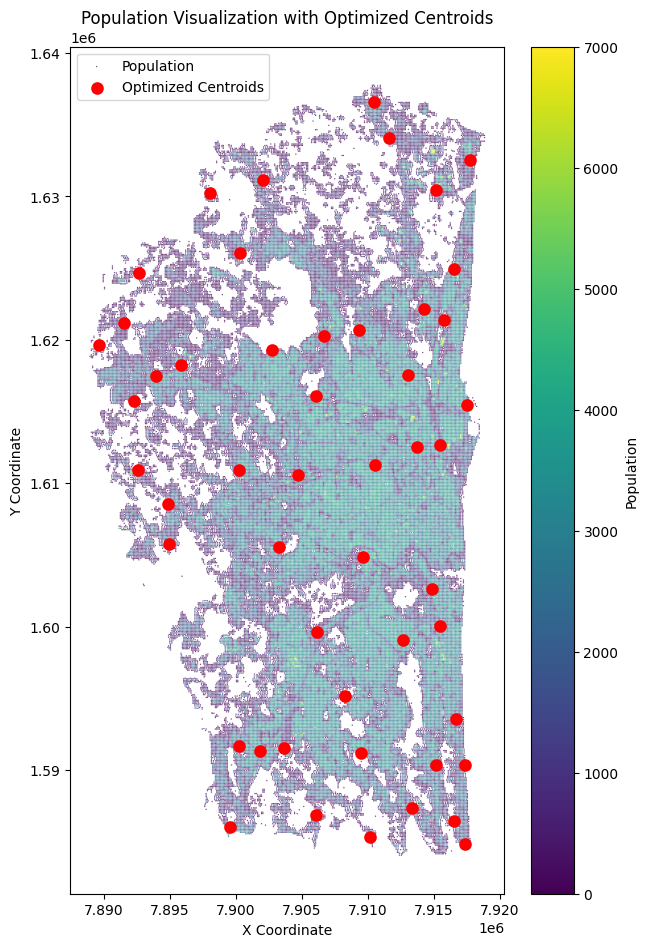

In [ ]:
# Get optimized centroids
optimized_centroids = scaler.inverse_transform(scaled_features[best_chromosome])

# Plot the map with optimized centroids
plt.figure(figsize=(7, 11))

# Plot data points (population density)
plt.scatter(pdensity['x'], pdensity['y'], c=pdensity['value'], cmap='viridis',
            alpha=0.7, s=1, edgecolors='none', label='Population')

# Plot optimized centroids
plt.scatter(optimized_centroids[:, 0], optimized_centroids[:, 1], s=200, c='red', marker='.',
            linewidths=2, label='Optimized Centroids')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Population Visualization with Optimized Centroids')
plt.colorbar(label='Population')
plt.legend()
plt.clim(0, 7000)
plt.show()

In [ ]:
# Apply KMeans clustering with sample weights
kmeans = KMeans(n_clusters=50, n_init=50, random_state=19, max_iter = 500, tol = 0.0000001, algorithm="elkan" )
# kmeans = KMeans(n_clusters=50, init= optimized_centroids, random_state=19, max_iter = 500, tol = 0.0000001, algorithm="elkan" )
kmeans.fit(scaled_features ,sample_weight=(weights**2))

KMeans(algorithm='elkan', max_iter=500, n_clusters=50, n_init=50,
       random_state=19, tol=1e-07)

In [ ]:
# Assign cluster labels back to the original DataFrame
pdensity['cluster'] = kmeans.labels_

In [ ]:
# Calculate centroids from scaled features and transform back to original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

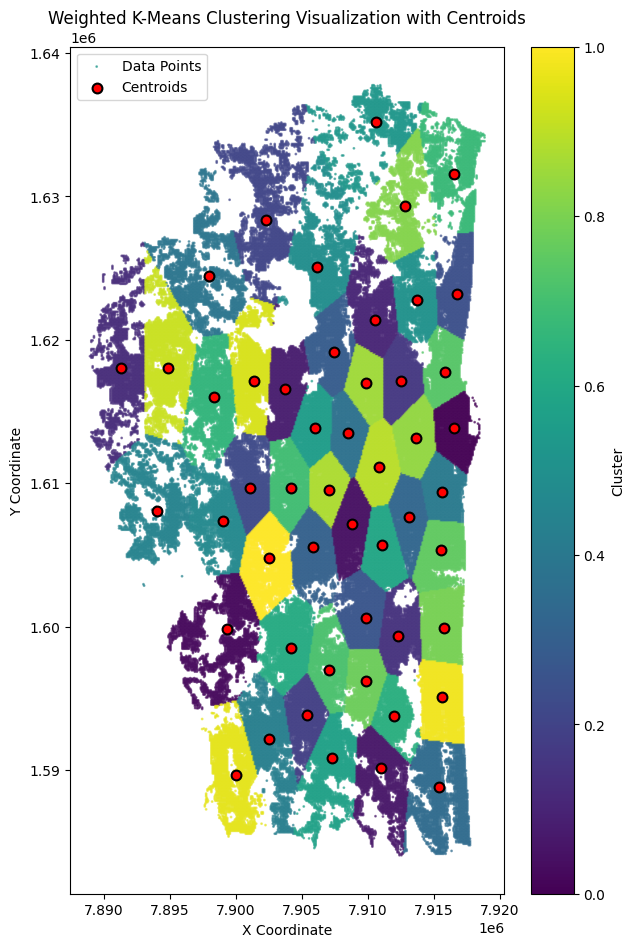

In [ ]:
# Plot the clusters with centroids
plt.figure(figsize=(7,11))

# Plot data points, color-coded by cluster
plt.scatter(pdensity['x'], pdensity['y'], c=pdensity['cluster'], cmap='viridis', alpha=0.6, label='Data Points',s=1)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='.', edgecolor='black', linewidth=1.5, label='Centroids')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Weighted K-Means Clustering Visualization with Centroids')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

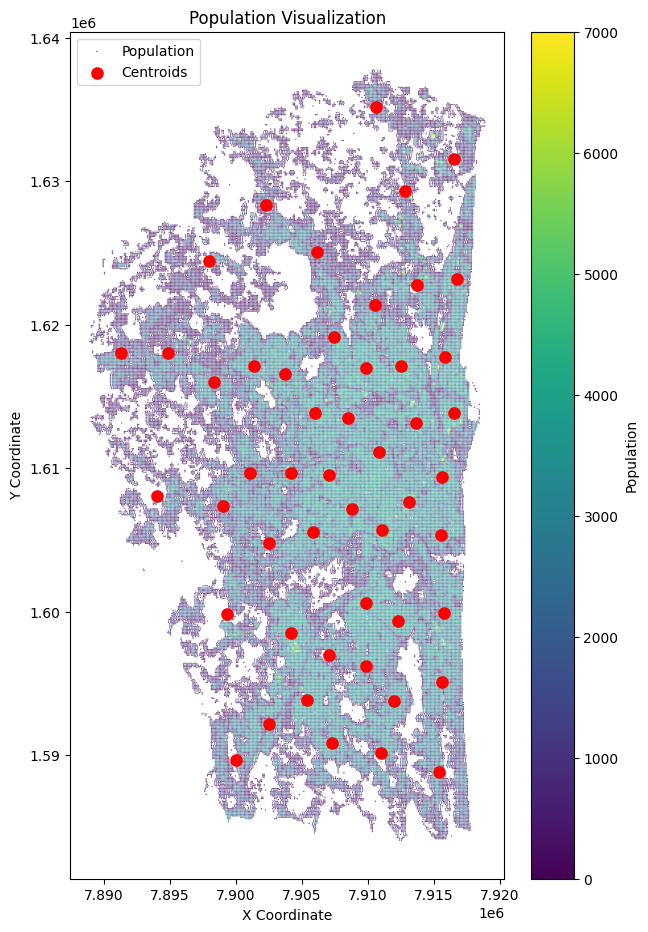

In [ ]:
plt.figure(figsize=(7,11))
plt.scatter(pdensity['x'], pdensity['y'], c=pdensity['value'], cmap='viridis',
            alpha=0.7, s=1, edgecolors='none', label='Population')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='.',
            linewidths=2, label='Centroids')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Population Visualization')
plt.colorbar(label='Population')
plt.legend()
plt.clim(0,7000)
plt.show()

In [ ]:
cluster_weights = []
for cluster_id in range(kmeans.n_clusters):  # Using kmeans.n_clusters for the number of clusters
    cluster_indices = np.where(pdensity['cluster'] == cluster_id)[0]  # Using pdensity['cluster'] for labels
    total_weight = np.sum(weights[cluster_indices])
    cluster_weights.append(total_weight)

# Display total weights
for cluster_id, total_weight in enumerate(cluster_weights):
    print(f"Cluster {cluster_id}: Total Weight = {total_weight}")

Cluster 0: Total Weight = 4078307.0
Cluster 1: Total Weight = 3955733.0
Cluster 2: Total Weight = 5103288.0
Cluster 3: Total Weight = 4352071.0
Cluster 4: Total Weight = 5355083.0
Cluster 5: Total Weight = 3791958.0
Cluster 6: Total Weight = 2727401.0
Cluster 7: Total Weight = 4517397.0
Cluster 8: Total Weight = 5402920.0
Cluster 9: Total Weight = 4390707.0
Cluster 10: Total Weight = 3480392.0
Cluster 11: Total Weight = 3955692.0
Cluster 12: Total Weight = 3903933.0
Cluster 13: Total Weight = 5289094.0
Cluster 14: Total Weight = 4339574.0
Cluster 15: Total Weight = 5305095.0
Cluster 16: Total Weight = 4968111.0
Cluster 17: Total Weight = 4686622.0
Cluster 18: Total Weight = 4460614.0
Cluster 19: Total Weight = 2332287.0
Cluster 20: Total Weight = 4358128.0
Cluster 21: Total Weight = 4851127.0
Cluster 22: Total Weight = 2768080.0
Cluster 23: Total Weight = 3748429.0
Cluster 24: Total Weight = 3138311.0
Cluster 25: Total Weight = 3668793.0
Cluster 26: Total Weight = 1496024.0
Cluster 27:

In [ ]:

# Calculate standard deviation of cluster weights
std_deviation_cluster_weights = np.std(cluster_weights)

# Print results
print("Standard Deviation of Cluster Weights:", std_deviation_cluster_weights)
#normal weights 1394062.0992863853
# squared weights 940016.4828678716
#cubed weights 965599.5624061786

Standard Deviation of Cluster Weights: 940016.4828678716


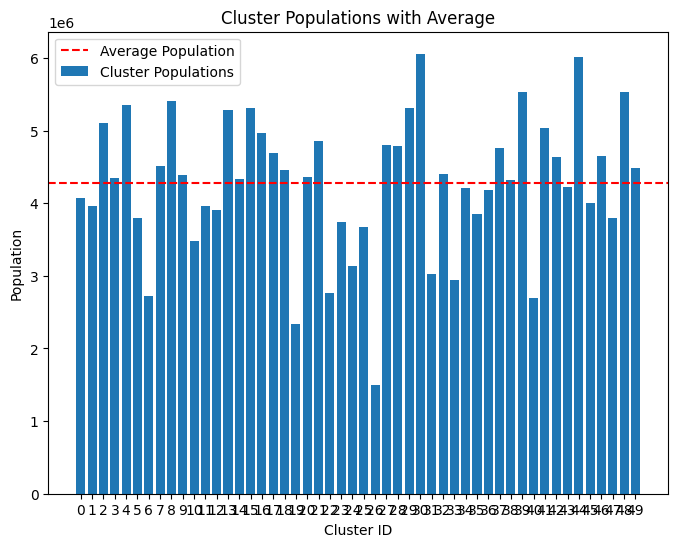

<ipython-input-55-4490b0c83a2f>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu')  # Red for above average, blue for below


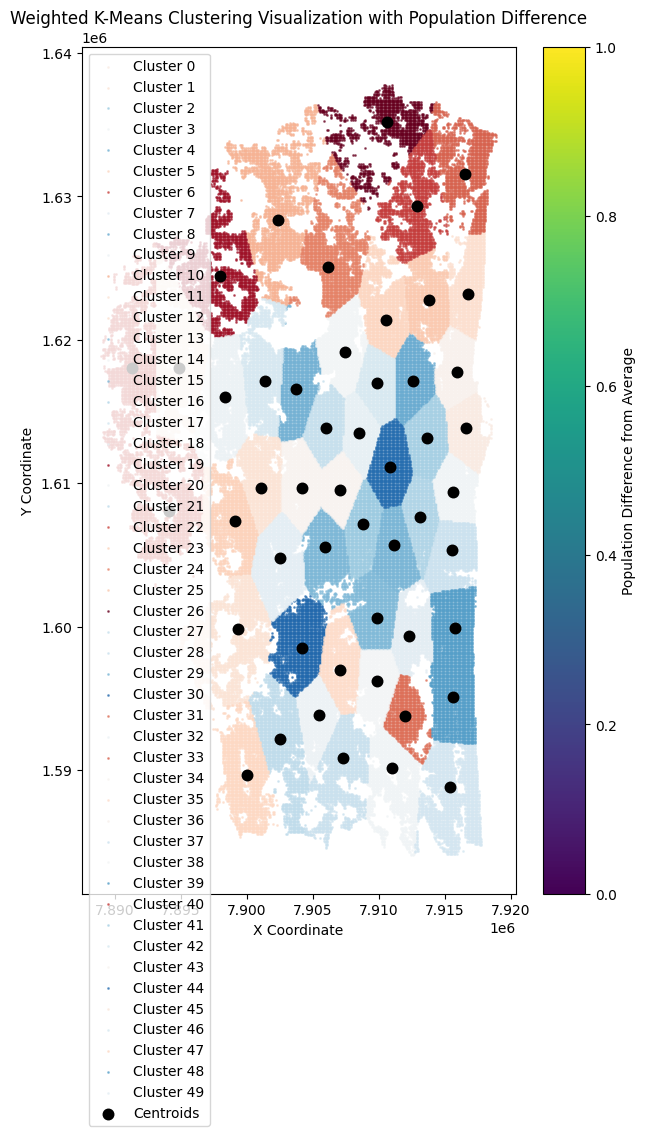

In [ ]:
average_population = np.mean(cluster_weights)

# Create the graph
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(range(len(cluster_weights)), cluster_weights, label='Cluster Populations')  # Bar plot for populations
plt.axhline(y=average_population, color='red', linestyle='--', label='Average Population')  # Horizontal line for average
plt.xlabel('Cluster ID')
plt.ylabel('Population')
plt.title('Cluster Populations with Average')
plt.xticks(range(len(cluster_weights)))  # Set x-axis ticks to cluster IDs
plt.legend()
plt.show()
#create colormap
cmap = plt.cm.get_cmap('RdBu')  # Red for above average, blue for below

# Create a list of colors for each cluster
cluster_colors = [cmap((weight - average_population) / (np.max(cluster_weights) - np.min(cluster_weights)) + 0.5)
                  for weight in cluster_weights]

# Plot the clusters with centroids and colored by population difference
plt.figure(figsize=(7, 11))

# Plot data points, color-coded by cluster
for cluster_id in range(len(cluster_weights)):
    cluster_data = pdensity[pdensity['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], c=[cluster_colors[cluster_id]],
                alpha=0.6, label=f'Cluster {cluster_id}', s=1)

# Plot centroids (you might need to adjust centroids variable)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='.',
            edgecolor='black', linewidth=1.5, label='Centroids')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Weighted K-Means Clustering Visualization with Population Difference')
plt.colorbar(label='Population Difference from Average')  # Add colorbar
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
reassignment_threshold = 0.02  # Adjust threshold

# Vectorized distance calculation for all data points to all centroids
all_distances = euclidean_distances(pdensity[['x', 'y']], centroids)

# Create a mask for valid reassignments based on distance and population constraints
valid_reassignments = (all_distances < np.tile(all_distances.min(axis=1)[:, None], (1, len(centroids))) - reassignment_threshold) & \
                     (np.tile(cluster_weights, (len(pdensity), 1)) < average_population * 1.2)

# Find the closest valid cluster for each data point
closest_valid_cluster = np.argmin(np.where(valid_reassignments, all_distances, np.inf), axis=1)

# Update cluster assignments and weights
pdensity['cluster'] = closest_valid_cluster

# Recalculate cluster weights
cluster_weights = pdensity.groupby('cluster')['value'].sum().values


In [ ]:
# Recalculating Centroids
new_centroids = []
for cluster_id in range(kmeans.n_clusters):
    cluster_indices = np.where(pdensity['cluster'] == cluster_id)[0]
    if len(cluster_indices) > 0:  # Check if cluster is not empty
        cluster_points = scaled_features[cluster_indices]
        new_centroid = np.mean(cluster_points, axis=0)
        new_centroids.append(new_centroid)
    else:
        # If cluster is empty, keep the original centroid
        new_centroids.append(kmeans.cluster_centers_[cluster_id])

# Update centroids
centroids = scaler.inverse_transform(np.array(new_centroids))


In [ ]:
# Plot the clusters with centroids
plt.figure(figsize=(7,11))

# Plot data points, color-coded by cluster
plt.scatter(pdensity['x'], pdensity['y'], c=pdensity['cluster'], cmap='viridis', alpha=0.6, label='Data Points',s=1)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='.', edgecolor='black', linewidth=1.5, label='Centroids')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Weighted K-Means Clustering Visualization with Centroids')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()
cluster_weights = []
for cluster_id in range(kmeans.n_clusters):  # Using kmeans.n_clusters for the number of clusters
    cluster_indices = np.where(pdensity['cluster'] == cluster_id)[0]  # Using pdensity['cluster'] for labels
    total_weight = np.sum(weights[cluster_indices])
    cluster_weights.append(total_weight)
for cluster_id, total_weight in enumerate(cluster_weights):
    print(f"Cluster {cluster_id}: Total Weight = {total_weight}")
# Calculate standard deviation of cluster weights
std_deviation_cluster_weights = np.std(cluster_weights)

# Print results
print("Standard Deviation of Cluster Weights:", std_deviation_cluster_weights)

In [ ]:
from scipy.spatial.distance import pdist, squareform
import networkx as nx
# Standard Deviation of Cluster Weights: 1394062.0992863853

In [ ]:
def construct_mst(centroids):
    # Calculating pairwise Euclidean distances between centroids
    distances = squareform(pdist(centroids, metric='euclidean'))

    # Creating a graph and adding edges with weights (distances)
    G = nx.Graph()
    num_centroids = len(centroids)

    # Add edges between every pair of centroids with distance as weight
    for i in range(num_centroids):
        for j in range(i + 1, num_centroids):
            G.add_edge(i, j, weight=distances[i, j])

    mst = nx.minimum_spanning_tree(G, weight='weight')

    return mst


In [ ]:
density_probability = weights / np.sum(weights)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Choose initial centroids based on the density probability
n_clustersi = 50  # Your desired number of clusters
initial_centroids_indices = np.random.choice(len(pdensity), size=n_clustersi, replace=False, p=density_probability)
initial_centroids = scaled_features[initial_centroids_indices]

# Now, use these initial centroids in your KMeans model
# kmeansi = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=50, random_state=1, max_iter=500, tol=0.0000001, algorithm="elkan")
# kmeansi.fit(scaled_features, sample_weight=(weights))

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

# ... (Your existing code for data loading and preprocessing)

def fitness_function(chromosome, scaled_features, weights, radius,distance_weight=2):

    """
    Calculates the fitness of a chromosome (set of initial centroids).

    Args:
        chromosome: A list of indices representing the initial centroids.
        scaled_features: Scaled features of the dataset.
        weights: Weights associated with each data point.
        radius: Radius for coverage and weight calculations.

    Returns:
        The fitness score of the chromosome.
    """
    centroids = scaled_features[chromosome]

    #total area covered by the points (maximize)
    hull = ConvexHull(centroids)
    total_area = (hull.volume**0.6)


    # Distance between centroids (minimize)
    distance_score = np.sum(pdist(centroids))

    # Coverage (maximize)
    distances_to_centroids = cdist(scaled_features, centroids)
    coverage = np.sum(np.min(distances_to_centroids, axis=1) <= radius)
    '''
    #weight (maximize)
    # Weight (modified for exclusive regions)
    cluster_weights = np.zeros(len(centroids))
    distances_to_centroids = cdist(scaled_features, centroids)  # Distances to all centroids

    cluster_weights = np.zeros(len(centroids))
    for i, centroid in enumerate(centroids):
        distances = np.linalg.norm(scaled_features - centroid, axis=1)

        # Calculate weighted average of weights within the radius
        weights_within_radius = weights[distances <= radius]
        distances_within_radius = distances[distances <= radius]

        # Inverse distance weighting (closer points have more influence)
        inverse_distances = 1 / (distances_within_radius + 1e-8)  # Avoid division by zero

        cluster_weights[i] = np.sum(weights_within_radius * inverse_distances) / np.sum(inverse_distances)

    weight_score = np.sum(cluster_weights)**6 '''

    # kmeans = KMeans(n_clusters=50, init= centroids, random_state=19, max_iter = 500, tol = 0.0000001, algorithm="elkan" )
    # kmeans.fit(scaled_features, sample_weight=weights**2)
    cluster_weights = []
    for cluster_id in range(50):  # Using kmeans.n_clusters for the number of clusters
        points = pdensity[['x', 'y']].values

        # Calculate distances between all points and all centroids
        distances = cdist(points, centroids)

        # Find the closest centroid for each point
        closest_centroid_indices = np.argmin(distances, axis=1)

        # Filter points closest to the given centroid
        closest_points_indices = np.where(closest_centroid_indices == cluster_id)[0]
        closest_points = pdensity.iloc[closest_points_indices]

        # Get the weights of these points
        weights = closest_points['value']

        # Calculate the sum of weights
        total_weight = np.sum(weights)

        cluster_weights.append(total_weight)

    std_deviation_cluster_weights = np.std(cluster_weights)

    # Combine scores (adjust weights as needed)
    fitness = distance_score - coverage + total_area - std_deviation_cluster_weights
    #fitness = ((weight_score)*total_area*distance_weight*distance_score)/(coverage)


    return fitness


def genetic_algorithm(scaled_features, weights, n_clusters, population_size, generations, mutation_rate, radius,distance_weight):
    """
    Runs the genetic algorithm to optimize initial centroids.

    Args:
        scaled_features: Scaled features of the dataset.
        weights: Weights associated with each data point.
        n_clusters: Number of clusters.
        population_size: Size of the population.
        generations: Number of generations to evolve.
        mutation_rate: Probability of mutation.
        radius: Radius for coverage and weight calculations.

    Returns:
        The best chromosome (set of initial centroid indices).
    """
    # Initialization
    population = [np.random.choice(len(scaled_features), size=n_clusters, replace=False) for _ in range(population_size)]

    for generation in range(generations):
        # Fitness evaluation
        fitness_scores = [fitness_function(chromosome, scaled_features, weights, radius,distance_weight) for chromosome in population]

        # Selection (tournament selection)
        selected_indices = []
        for _ in range(population_size):
            tournament = np.random.choice(population_size, size=2, replace=False)
            winner = tournament[np.argmax(np.array(fitness_scores)[tournament])]
            selected_indices.append(winner)

        # Crossover (single-point crossover)
        offspring = []
        for i in range(0, population_size, 2):
            parent1 = population[selected_indices[i]]
            parent2 = population[selected_indices[i + 1]]
            crossover_point = np.random.randint(1, n_clusters)
            child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            offspring.extend([child1, child2])

        # Mutation
        for i in range(population_size):
            if np.random.rand() < mutation_rate:
                random_index = np.random.randint(n_clusters)
                offspring[i][random_index] = np.random.choice(len(scaled_features))

        # Replace population with offspring
        population = offspring

    # Return best chromosome
    best_chromosome = population[np.argmax(fitness_scores)]
    return best_chromosome

# Run genetic algorithm
n_clusters = 50
population_size = 100
generations = 500
mutation_rate = 1
radius = 0.006  # Adjust as needed
distance_weight = 10

best_chromosome = genetic_algorithm(scaled_features, weights, n_clusters, population_size, generations, mutation_rate, radius,distance_weight)

# Use optimized

NameError: name 'scaled_features' is not defined

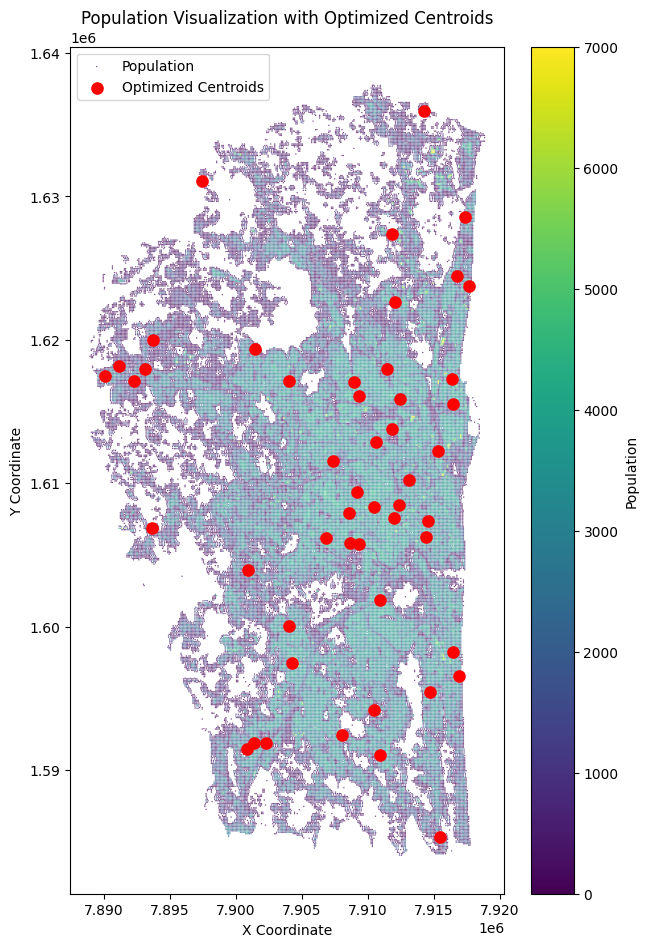

In [ ]:
# Get optimized centroids
optimized_centroids = scaler.inverse_transform(scaled_features[best_chromosome])

# Plot the map with optimized centroids
plt.figure(figsize=(7, 11))

# Plot data points (population density)
plt.scatter(pdensity['x'], pdensity['y'], c=pdensity['value'], cmap='viridis',
            alpha=0.7, s=1, edgecolors='none', label='Population')

# Plot optimized centroids
plt.scatter(optimized_centroids[:, 0], optimized_centroids[:, 1], s=200, c='red', marker='.',
            linewidths=2, label='Optimized Centroids')

# Customize the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Population Visualization with Optimized Centroids')
plt.colorbar(label='Population')
plt.legend()
plt.clim(0, 7000)
plt.show()